# Multi Class Classification with NLLLoss

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import time
import numpy as np
import matplotlib.pyplot as plt
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
train_data = './Dataset/train/'
test_data = './Dataset/test/'

## Custom Loader

In [63]:
img_size = 224

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Grayscale(),
    transforms.Resize((img_size,img_size))])


class CustomLoader(torch.utils.data.Dataset):
    def __init__(self, data_path, transform):
        self.path = data_path
        self.files = []
        for dir_path, currentDirectory, dir_files in os.walk(data_path):
            for file in dir_files:
                self.files.append(dir_path + '/' + file)
        self.indices = len(self.files)
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        label = int(self.files[idx].split('-')[0][-1:])

        return image.to(device), torch.tensor(label).long().to(device)

    def __len__(self):
        return self.indices

tensor(1, device='cuda:0')


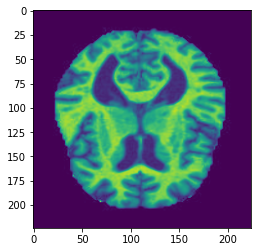

In [16]:
data = CustomLoader(train_data, transform)
im, label = data[4850]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

## CNN Model

In [17]:
def conv_layer(ni,no,kernel_size,stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)
    )

def get_model():
    model = nn.Sequential(
        conv_layer(1, 64, 3),
        conv_layer(64, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        nn.Flatten(),
        nn.Linear(512, 4),
        nn.LogSoftmax(dim=1)
    ).to(device)
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)

    return model, loss_fn, optimizer

from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, (1, 224, 224));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]             640
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

## Load Train and Test

In [64]:
train_data_size = 5121
test_data_size = 1279

def get_data(train_data, test_data):
    train = CustomLoader(train_data, transform)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)

    test = CustomLoader(test_data, transform)
    test_dl = DataLoader(test, batch_size=32, shuffle=True, drop_last=True)

    return trn_dl, test_dl

trn_dl, test_dl = get_data(train_data, test_data)
model, loss_fn, optimizer = get_model()

## Train model

In [19]:
def train_and_validate(model, loss_criterion, optimizer, epochs=1):
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(trn_dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        #          print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - No gradient tracking needed
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(trn_dl):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

        #             print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/test_data_size
        avg_valid_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        torch.save(model,'./model/model_'+str(epoch)+'.pt')

    return model, history, best_epoch

In [33]:
num_epochs = 3
trained_model, history, best_epoch = train_and_validate(model, loss_fn, optimizer, num_epochs)

Epoch: 1/3
Epoch: 2/3
Epoch: 3/3


### Plot results

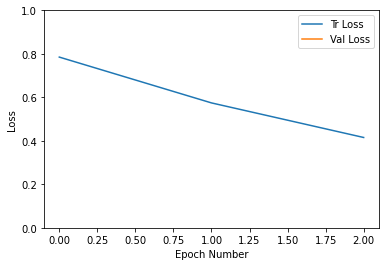

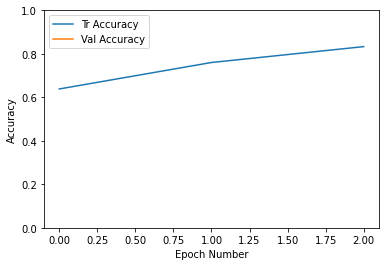

In [61]:
torch.save(history, './model/classifier_real_images/history.pt')
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig('./model/classifier_real_images/loss_curve.png')
plt.show()
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('./model/classifier_real_images/accuracy_curve.png')
plt.show()

tensor(1, device='cuda:0')

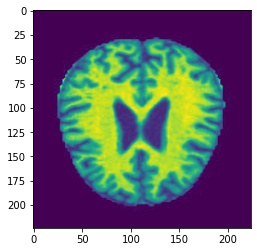

In [56]:
data = CustomLoader(test_data, transform)
im, label = data[1001]
plt.imshow(im.permute(1,2,0).cpu())
label

In [57]:
test = im.unsqueeze(0)
prediction = model(test).cpu().detach().numpy()
pred = np.exp(prediction)/np.sum(np.exp(prediction))
pred

array([[7.3142463e-01, 2.5595552e-01, 1.2610096e-02, 9.8479077e-06]],
      dtype=float32)

In [32]:
history[:,0:2]

array([[0.97656692, 3.29842944]])

## Train with GAN Images

In [65]:
train_data = './gan_images/train/'
test_data = './gan_images/test/'

trn_dl, test_dl = get_data(train_data, test_data)
model, loss_fn, optimizer = get_model()

tensor(3, device='cuda:0')

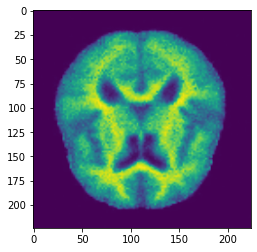

In [68]:
data = CustomLoader(train_data, transform)
im, label = data[6051]
plt.imshow(im.permute(1,2,0).cpu())
label

In [69]:
num_epochs = 3
trained_model, history, best_epoch = train_and_validate(model, loss_fn, optimizer, num_epochs)

Epoch: 1/3
Epoch: 2/3
Epoch: 3/3


### Plot results

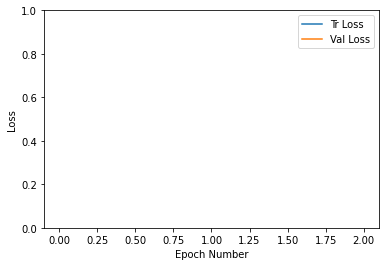

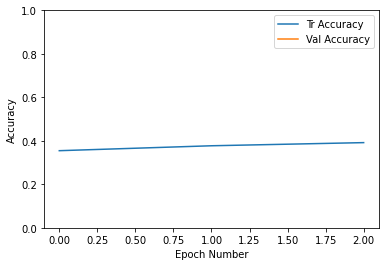

In [70]:
torch.save(history, './model/classifier_gan_images/history.pt')
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig('./model/classifier_gan_images/loss_curve.png')
plt.show()
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('./model/classifier_gan_images/accuracy_curve.png')
plt.show()